In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from pandas.core.dtypes.common import is_numeric_dtype

In [132]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'preprocessed_df.csv')
NEW_DATASET = os.path.join(DATA_FOLDER, 'final_dataset.csv')

In [133]:
df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

## Outliers using KNN

In [134]:
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
import networkx as nx

n_neighbors = 20
normalized_df = (df[numerical_attr_list] - df[numerical_attr_list].min()) / (df[numerical_attr_list].max() - df[numerical_attr_list].min())
G = kneighbors_graph(normalized_df.values, n_neighbors=n_neighbors, mode='distance', p=np.inf)
G = nx.DiGraph(G)
dictator = nx.to_dict_of_dicts(G);

In [135]:
score = np.zeros(len(normalized_df))
for element in dictator.keys():
    mean_dist = 0
    for child in dictator[element].keys():
        mean_dist += dictator[element][child]["weight"] / n_neighbors
    score[element] = mean_dist

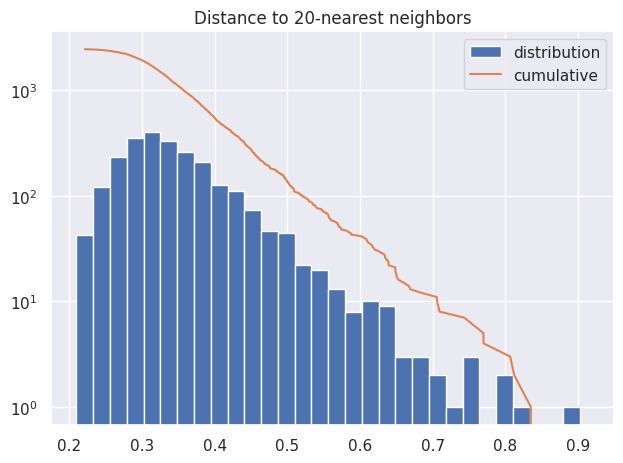

In [136]:
plt.hist(score, bins=30, align="left", label="distribution")
plt.plot(np.flip(np.sort(score)), np.linspace(0, len(df), len(df)), label="cumulative")
plt.yscale('log')
plt.title(f'Distance to {n_neighbors}-nearest neighbors')
plt.legend()
plt.show()

In [137]:
from sklearn.manifold import Isomap

reducer = Isomap(n_neighbors=n_neighbors, p=10)
embedding = reducer.fit_transform(normalized_df)
print(embedding.shape)

(2452, 2)


71


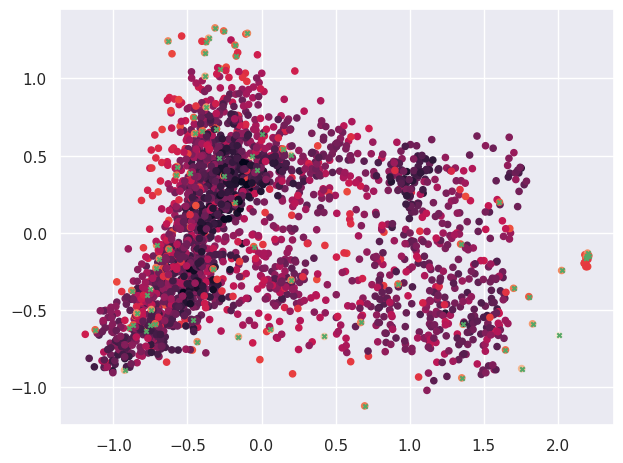

In [138]:
plt.scatter(*embedding.T, c=np.log10(score), s=20)
cutted = embedding[score > 0.55]
print(len(cutted))
plt.scatter(*cutted.T, marker="x", color="g", s=10)
plt.show()

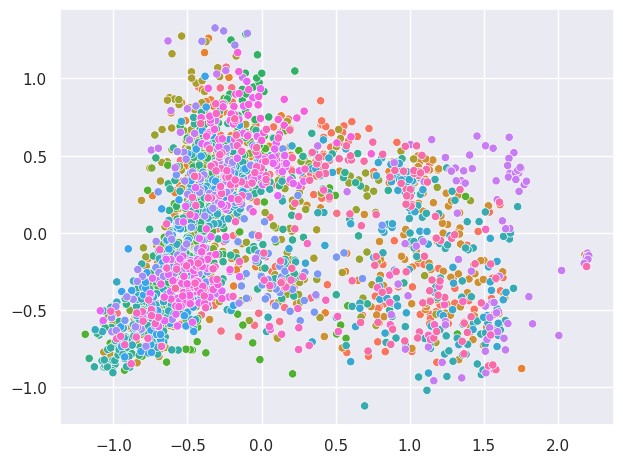

In [139]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df['actor'], legend=False)
plt.show()

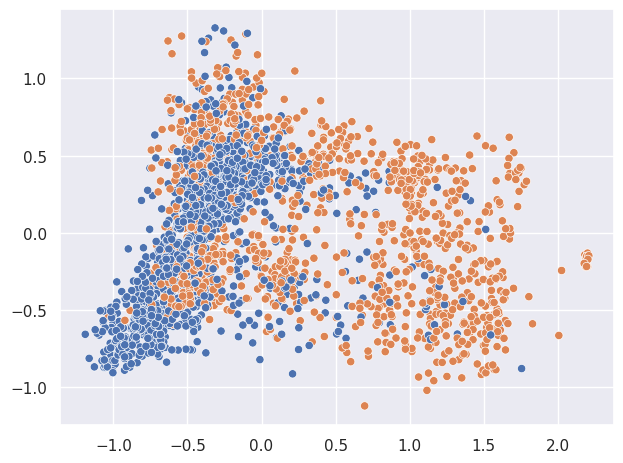

In [140]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df['sex'], legend=False)
plt.show()

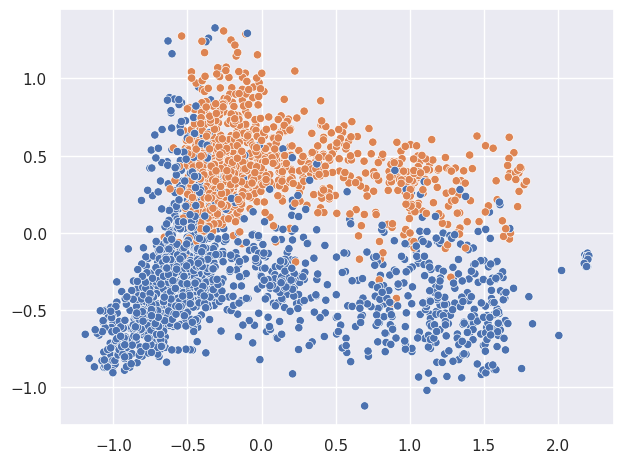

In [141]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df["vocal_channel"], legend=False)
plt.show()

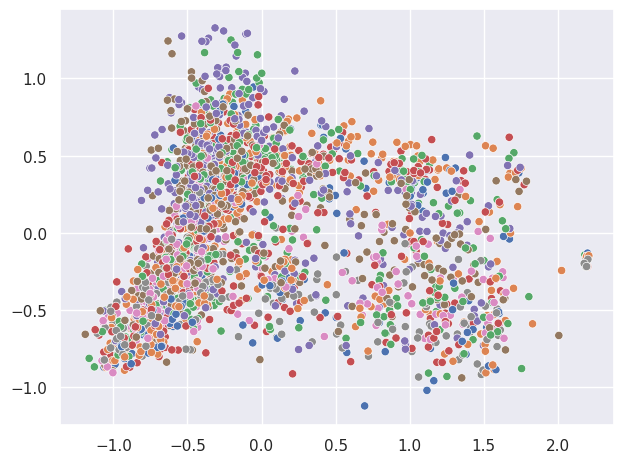

In [142]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df["emotion"], legend=False)
plt.show()

In [143]:
from sklearn.decomposition import PCA

def eigenvalues_plot(X):
    pca = PCA()
    pca.fit(X)
    eigenvalues = pca.explained_variance_

    variance = eigenvalues / np.sum(eigenvalues)

    # 50 eigenvalues
    components = np.arange(1, 51)
    variance = variance[:50]

    plt.plot(components, variance, 'bo-')
    plt.xlabel('Principal components')
    plt.ylabel('Variance')
    plt.grid(True)
    plt.show()

## LOF

In [144]:
df_sex_m = df[df['sex'] == 'M']
df_sex_f = df[df['sex'] == 'F']

df_sex_m = df_sex_m[numerical_attr_list]
df_sex_f = df_sex_f[numerical_attr_list]

In [145]:
scaler = MinMaxScaler()
X_sex_m = scaler.fit_transform(df_sex_m)
X_sex_f = scaler.fit_transform(df_sex_f)

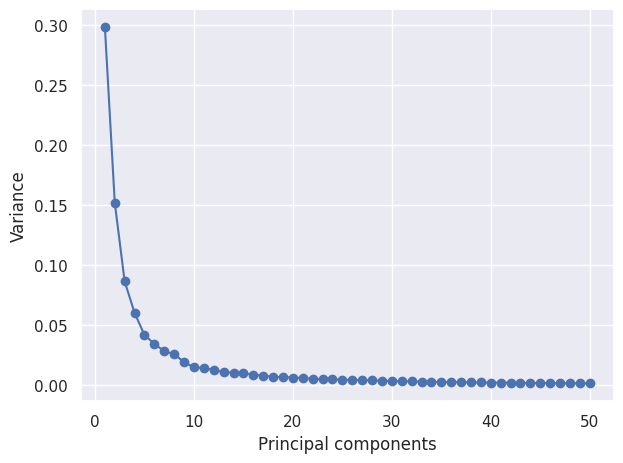

In [146]:
eigenvalues_plot(X_sex_m)

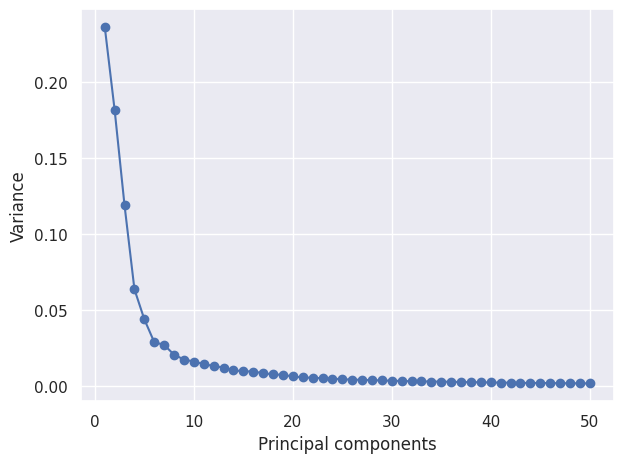

In [147]:
eigenvalues_plot(X_sex_f)

In [148]:
pca = PCA(n_components=5)
X_sex_m = pca.fit_transform(X_sex_m)
X_sex_f = pca.fit_transform(X_sex_f)

In [149]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_jobs=-1)
outliers = clf.fit_predict(X_sex_m)

In [150]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([   8, 1240]))

In [151]:
df_sex_m['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_sex_m['is_outlier'] = is_outlier

In [152]:
clf = LocalOutlierFactor(n_jobs=-1)
outliers = clf.fit_predict(X_sex_f)

In [153]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([   5, 1199]))

In [154]:
df_sex_f['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_sex_f['is_outlier'] = is_outlier

In [155]:
df['outlier_score_sex'] = df_sex_f['outlier_score'].combine_first(df_sex_m['outlier_score'])
df['is_outlier_sex'] = df_sex_f['is_outlier'].combine_first(df_sex_m['is_outlier'])
df[['outlier_score_sex', 'is_outlier_sex']]

,outlier_score_sex,is_outlier_sex
0,-1.162793,False
1,-1.038030,False
2,-1.077281,False
3,-1.020369,False
4,-1.081104,False
...,...,...
2447,-0.988517,False
2448,-1.006350,False
2449,-1.010687,False
2450,-1.029461,False


In [156]:
df_speech = df[df['vocal_channel'] == 'speech']
df_song = df[df['vocal_channel'] == 'song']

df_speech = df_speech[numerical_attr_list]
df_song = df_song[numerical_attr_list]

In [157]:
X_speech = scaler.fit_transform(df_speech)
X_song = scaler.fit_transform(df_song)

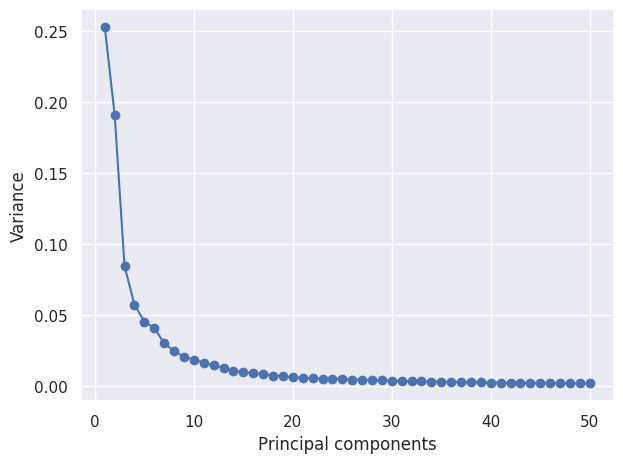

In [158]:
eigenvalues_plot(X_speech)

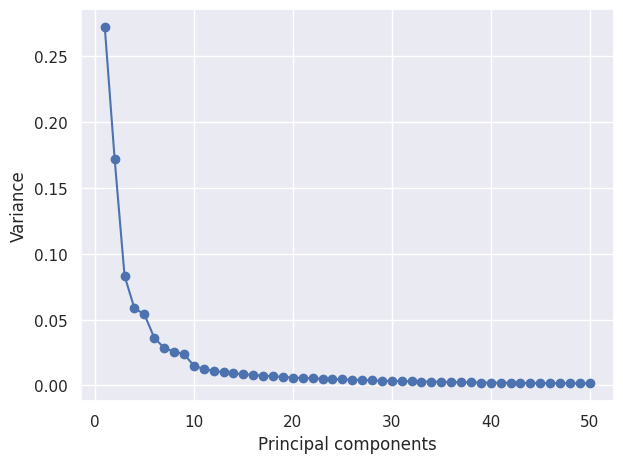

In [159]:
eigenvalues_plot(X_song)

In [160]:
pca = PCA(n_components=5)
X_speech = pca.fit_transform(X_speech)
X_song = pca.fit_transform(X_song)

In [161]:
clf = LocalOutlierFactor(n_jobs=-1)
outliers = clf.fit_predict(X_speech)

In [162]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([   7, 1433]))

In [163]:
df_speech['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_speech['is_outlier'] = is_outlier

In [164]:
clf = LocalOutlierFactor(n_jobs=-1)
outliers = clf.fit_predict(X_song)

In [165]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([   8, 1004]))

In [166]:
df_song['outlier_score'] = clf.negative_outlier_factor_

is_outlier = np.where(outliers == 1, False, True)
df_song['is_outlier'] = is_outlier

In [167]:
df['outlier_score_vc'] = df_song['outlier_score'].combine_first(df_speech['outlier_score'])
df['is_outlier_vc'] = df_song['is_outlier'].combine_first(df_speech['is_outlier'])
df[['outlier_score_vc', 'is_outlier_vc']]

,outlier_score_vc,is_outlier_vc
0,-1.194878,False
1,-1.080910,False
2,-1.137767,False
3,-1.020084,False
4,-1.069881,False
...,...,...
2447,-1.002921,False
2448,-1.018316,False
2449,-1.029578,False
2450,-1.010099,False


#### now that all outlier scores have been calculated, it is possible to select the top 1%

In [168]:
df_outliers = df.loc[(df['is_outlier_sex'] == True) | (df['is_outlier_vc'] == True)]

In [169]:
scores = df_outliers['outlier_score_sex'] + df_outliers['outlier_score_vc']
scores_vc = df_outliers['outlier_score_vc']
scores_sex = df_outliers['outlier_score_sex']
scores

35     -2.840761
40     -2.642123
235    -2.934473
382    -3.605941
512    -2.670144
515    -2.628189
589    -3.247025
698    -3.821586
832    -3.782122
841    -2.998238
843    -3.169814
903    -2.974456
1176   -2.700378
1283   -2.731850
1390   -3.162708
1756   -2.910169
1757   -3.074570
1877   -2.991210
1878   -2.708623
2210   -2.969695
2287   -2.958663
2392   -4.248094
dtype: float64

In [170]:
# find top 1% outliers
one_percent = int(df.shape[0] / 100)

top1pct_outliers_sex_lof = scores_sex.nsmallest(one_percent)
top1pct_outliers_vc_lof = scores_vc.nsmallest(one_percent)
top1pct_outliers_lof = scores.nsmallest(one_percent)
top1pct_outliers_lof

2392   -4.248094
698    -3.821586
832    -3.782122
382    -3.605941
589    -3.247025
843    -3.169814
1390   -3.162708
1757   -3.074570
841    -2.998238
1877   -2.991210
903    -2.974456
2210   -2.969695
2287   -2.958663
235    -2.934473
1756   -2.910169
35     -2.840761
1283   -2.731850
1878   -2.708623
1176   -2.700378
512    -2.670144
40     -2.642123
515    -2.628189
dtype: float64

In [171]:
new_columns_names = {'is_outlier_sex': 'is_outlier_sex_lof', 'is_outlier_vc': 'is_outlier_vc_lof'}
df = df.rename(new_columns_names, axis=1)
df = df.drop(['outlier_score_sex', 'outlier_score_vc'], axis=1)

## Isolation Forest

In [172]:
df_sex_m = df[df['sex'] == 'M']
df_sex_f = df[df['sex'] == 'F']

df_sex_m = df_sex_m[numerical_attr_list]
df_sex_f = df_sex_f[numerical_attr_list]

In [173]:
X_sex_m = scaler.fit_transform(df_sex_m)
X_sex_f = scaler.fit_transform(df_sex_f)

In [174]:
from sklearn.ensemble import IsolationForest

isfo = IsolationForest(n_jobs=-1)
outliers = isfo.fit_predict(X_sex_m)

In [175]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  44, 1204]))

In [176]:
df_sex_m['outlier_score'] = isfo.score_samples(df_sex_m)

is_outlier = np.where(outliers == 1, False, True)
df_sex_m['is_outlier'] = is_outlier

/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [177]:
isfo = IsolationForest(n_jobs=-1)
outliers = isfo.fit_predict(X_sex_f)

In [178]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  50, 1154]))

In [179]:
df_sex_f['outlier_score'] = isfo.score_samples(df_sex_f)

is_outlier = np.where(outliers == 1, False, True)
df_sex_f['is_outlier'] = is_outlier

/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [180]:
df['outlier_score_sex'] = df_sex_f['outlier_score'].combine_first(df_sex_m['outlier_score'])
df['is_outlier_sex'] = df_sex_f['is_outlier'].combine_first(df_sex_m['is_outlier'])
df[['outlier_score_sex', 'is_outlier_sex']]

,outlier_score_sex,is_outlier_sex
0,-0.747464,False
1,-0.746516,False
2,-0.746873,False
3,-0.744138,False
4,-0.751435,False
...,...,...
2447,-0.721290,False
2448,-0.715955,False
2449,-0.720517,False
2450,-0.711667,False


In [181]:
df_speech = df[df['vocal_channel'] == 'speech']
df_song = df[df['vocal_channel'] == 'song']

df_speech = df_speech[numerical_attr_list]
df_song = df_song[numerical_attr_list]

In [182]:
X_speech = scaler.fit_transform(df_speech)
X_song = scaler.fit_transform(df_song)

In [183]:
isfo = IsolationForest(n_jobs=-1)
outliers = isfo.fit_predict(X_speech)

In [184]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  50, 1390]))

In [185]:
df_speech['outlier_score'] = isfo.score_samples(df_speech)

is_outlier = np.where(outliers == 1, False, True)
df_speech['is_outlier'] = is_outlier

/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [186]:
isfo = IsolationForest(n_jobs=-1)
outliers = isfo.fit_predict(X_song)

In [187]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 46, 966]))

In [188]:
df_song['outlier_score'] = isfo.score_samples(df_song)

is_outlier = np.where(outliers == 1, False, True)
df_song['is_outlier'] = is_outlier

/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [189]:
df['outlier_score_vc'] = df_speech['outlier_score'].combine_first(df_song['outlier_score'])
df['is_outlier_vc'] = df_speech['is_outlier'].combine_first(df_song['is_outlier'])
df[['outlier_score_vc', 'is_outlier_vc']]

,outlier_score_vc,is_outlier_vc
0,-0.745763,False
1,-0.737992,False
2,-0.737824,False
3,-0.732171,False
4,-0.734798,False
...,...,...
2447,-0.690201,False
2448,-0.694571,False
2449,-0.682680,False
2450,-0.683658,False


#### now that all outlier scores have been calculated, it is possible to select the top 1%

In [190]:
df_outliers = df.loc[(df['is_outlier_sex'] == True) | (df['is_outlier_vc'] == True)]

In [191]:
scores = df_outliers['outlier_score_sex'] + df_outliers['outlier_score_vc']
scores_vc = df_outliers['outlier_score_vc']
scores_sex = df_outliers['outlier_score_sex']
scores

35     -1.491447
40     -1.464002
92     -1.461210
94     -1.438520
95     -1.447812
          ...   
2210   -1.429824
2232   -1.438153
2235   -1.434842
2383   -1.445592
2441   -1.409707
Length: 127, dtype: float64

In [192]:
# find top 1% outliers
one_percent = int(df.shape[0] / 100)

top1pct_outliers_sex_isfo = scores_sex.nsmallest(one_percent)
top1pct_outliers_vc_isfo = scores_vc.nsmallest(one_percent)
top1pct_outliers_isfo = scores.nsmallest(one_percent)
top1pct_outliers_isfo

841    -1.503531
425    -1.499189
1283   -1.498087
840    -1.497222
243    -1.496494
240    -1.496180
853    -1.493785
1879   -1.493670
1492   -1.493052
1702   -1.492547
35     -1.491447
832    -1.491353
1861   -1.491353
657    -1.490688
659    -1.489328
658    -1.488111
242    -1.487741
1075   -1.487666
1968   -1.487489
241    -1.486847
1802   -1.486746
248    -1.486344
656    -1.485516
1803   -1.485062
dtype: float64

In [193]:
new_columns_names = {'is_outlier_sex': 'is_outlier_sex_isfo', 'is_outlier_vc': 'is_outlier_vc_isfo'}
df = df.rename(new_columns_names, axis=1)
df = df.drop(['outlier_score_sex', 'outlier_score_vc'], axis=1)

## ABOD

In [194]:
df_sex_m = df[df['sex'] == 'M']
df_sex_f = df[df['sex'] == 'F']

df_sex_m = df_sex_m[numerical_attr_list]
df_sex_f = df_sex_f[numerical_attr_list]

In [195]:
X_sex_m = scaler.fit_transform(df_sex_m)
X_sex_f = scaler.fit_transform(df_sex_f)

In [196]:
pca = PCA(n_components=5)
X_sex_m = pca.fit_transform(X_sex_m)
X_sex_f = pca.fit_transform(X_sex_f)

In [197]:
from pyod.models.abod import ABOD

abod = ABOD()
outliers = abod.fit_predict(X_sex_m)

/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [198]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([1123,  125]))

In [199]:
df_sex_m['outlier_score'] = abod.decision_scores_

# using ABOD, 1 -> outlier && 0 -> inlier
is_outlier = np.where(outliers == 1, True, False)
df_sex_m['is_outlier'] = is_outlier

In [200]:
abod = ABOD()
outliers = abod.fit_predict(X_sex_f)

/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [201]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([1083,  121]))

In [202]:
df_sex_f['outlier_score'] = abod.decision_scores_

# using ABOD, 1 -> outlier && 0 -> inlier
is_outlier = np.where(outliers == 1, True, False)
df_sex_f['is_outlier'] = is_outlier

In [203]:
df['outlier_score_sex'] = df_sex_f['outlier_score'].combine_first(df_sex_m['outlier_score'])
df['is_outlier_sex'] = df_sex_f['is_outlier'].combine_first(df_sex_m['is_outlier'])
df[['outlier_score_sex', 'is_outlier_sex']]

,outlier_score_sex,is_outlier_sex
0,-1.051924,False
1,-4.162027,False
2,-4.905102,False
3,-18.500808,False
4,-1.751391,False
...,...,...
2447,-9.671614,False
2448,-2.837868,False
2449,-6.575145,False
2450,-1.743635,False


In [204]:
df_speech = df[df['vocal_channel'] == 'speech']
df_song = df[df['vocal_channel'] == 'song']

df_speech = df_speech[numerical_attr_list]
df_song = df_song[numerical_attr_list]

In [205]:
X_speech = scaler.fit_transform(df_speech)
X_song = scaler.fit_transform(df_song)

In [206]:
X_speech = pca.fit_transform(X_speech)
X_song = pca.fit_transform(X_song)

In [207]:
abod = ABOD()
outliers = abod.fit_predict(X_speech)

/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [208]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([1296,  144]))

In [209]:
df_speech['outlier_score'] = abod.decision_scores_

# using ABOD, 1 -> outlier && 0 -> inlier
is_outlier = np.where(outliers == 1, True, False)
df_speech['is_outlier'] = is_outlier

In [210]:
abod = ABOD()
outliers = abod.fit_predict(X_song)

/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [211]:
np.unique(outliers, return_counts=True)

(array([0, 1]), array([910, 102]))

In [212]:
df_song['outlier_score'] = abod.decision_scores_

# using ABOD, 1 -> outlier && 0 -> inlier
is_outlier = np.where(outliers == 1, True, False)
df_song['is_outlier'] = is_outlier

In [213]:
df['outlier_score_vc'] = df_speech['outlier_score'].combine_first(df_song['outlier_score'])
df['is_outlier_vc'] = df_speech['is_outlier'].combine_first(df_song['is_outlier'])
df[['outlier_score_vc', 'is_outlier_vc']]

,outlier_score_vc,is_outlier_vc
0,-1.671983,False
1,-16.980592,False
2,-14.786673,False
3,-39.485616,False
4,-10.054050,False
...,...,...
2447,-19.292628,False
2448,-3.092068,False
2449,-1.681719,False
2450,-3.192283,False


#### now that all outlier scores have been calculated, it is possible to select the top 1%

In [214]:
df_outliers = df.loc[(df['is_outlier_sex'] == True) | (df['is_outlier_vc'] == True)]

In [215]:
scores = df_outliers['outlier_score_sex'] + df_outliers['outlier_score_vc']
scores_vc = df_outliers['outlier_score_vc']
scores_sex = df_outliers['outlier_score_sex']
scores

8      -1.415147
22     -0.261057
32     -0.839176
34     -2.203864
35     -0.076274
          ...   
2413   -0.645278
2426   -0.534250
2440   -0.375282
2441   -0.671846
2443   -0.993601
Length: 376, dtype: float64

In [216]:
# find top 1% outliers
one_percent = int(df.shape[0] / 100)
# using ABOD the larger the value, the more abnormal the data
top1pct_outliers_sex_abod = scores_sex.nlargest(one_percent)
top1pct_outliers_vc_abod = scores_vc.nlargest(one_percent)
top1pct_outliers_abod = scores.nlargest(one_percent)
top1pct_outliers_abod

698    -0.012778
843    -0.023503
1702   -0.024848
832    -0.051048
382    -0.052845
2392   -0.055390
718    -0.071297
35     -0.076274
1819   -0.086562
903    -0.115450
1966   -0.136387
715    -0.142966
1283   -0.156512
2210   -0.188216
1877   -0.209483
235    -0.213517
842    -0.216909
841    -0.225929
1861   -0.228028
2011   -0.233571
701    -0.237120
2227   -0.237911
22     -0.261057
355    -0.261919
dtype: float64

In [217]:
new_columns_names = {'is_outlier_sex': 'is_outlier_sex_abod', 'is_outlier_vc': 'is_outlier_vc_abod'}
df = df.rename(new_columns_names, axis=1)
df = df.drop(['outlier_score_sex', 'outlier_score_vc'], axis=1)

## Compare the outliers obtained by the three different methods

In [218]:
display(top1pct_outliers_lof, top1pct_outliers_sex_lof, top1pct_outliers_vc_lof)

2392   -4.248094
698    -3.821586
832    -3.782122
382    -3.605941
589    -3.247025
843    -3.169814
1390   -3.162708
1757   -3.074570
841    -2.998238
1877   -2.991210
903    -2.974456
2210   -2.969695
2287   -2.958663
235    -2.934473
1756   -2.910169
35     -2.840761
1283   -2.731850
1878   -2.708623
1176   -2.700378
512    -2.670144
40     -2.642123
515    -2.628189
dtype: float64

2392   -2.256192
832    -1.855744
382    -1.830520
698    -1.701655
589    -1.668553
1877   -1.654057
35     -1.570687
1176   -1.566025
1878   -1.555414
40     -1.528676
1390   -1.522330
1283   -1.520908
1756   -1.512138
841    -1.494721
2210   -1.417028
903    -1.408690
1757   -1.404170
235    -1.356053
843    -1.350354
2287   -1.248862
512    -1.162852
515    -0.988994
Name: outlier_score_sex, dtype: float64

698    -2.119931
2392   -1.991902
832    -1.926377
843    -1.819460
382    -1.775420
2287   -1.709801
1757   -1.670400
1390   -1.640378
515    -1.639194
589    -1.578472
235    -1.578420
903    -1.565766
2210   -1.552668
512    -1.507291
841    -1.503518
1756   -1.398031
1877   -1.337153
35     -1.270074
1283   -1.210942
1878   -1.153210
1176   -1.134353
40     -1.113447
Name: outlier_score_vc, dtype: float64

In [219]:
display(top1pct_outliers_isfo, top1pct_outliers_sex_isfo, top1pct_outliers_vc_isfo)

841    -1.503531
425    -1.499189
1283   -1.498087
840    -1.497222
243    -1.496494
240    -1.496180
853    -1.493785
1879   -1.493670
1492   -1.493052
1702   -1.492547
35     -1.491447
832    -1.491353
1861   -1.491353
657    -1.490688
659    -1.489328
658    -1.488111
242    -1.487741
1075   -1.487666
1968   -1.487489
241    -1.486847
1802   -1.486746
248    -1.486344
656    -1.485516
1803   -1.485062
dtype: float64

484    -0.761818
35     -0.760620
1702   -0.759561
659    -0.759078
841    -0.758685
840    -0.758399
486    -0.757856
308    -0.757465
292    -0.757432
897    -0.757238
1756   -0.756078
657    -0.755494
903    -0.755297
1759   -0.755223
1879   -0.754980
425    -0.754950
656    -0.754712
243    -0.754563
311    -0.754396
1492   -0.753959
92     -0.753660
248    -0.753442
242    -0.753376
240    -0.752834
Name: outlier_score_sex, dtype: float64

1968   -0.754681
1801   -0.750366
1283   -0.750342
1803   -0.749668
1938   -0.748987
1802   -0.748654
560    -0.747284
1800   -0.747126
1861   -0.745771
841    -0.744846
425    -0.744239
954    -0.743985
1966   -0.743833
240    -0.743346
1974   -0.742173
243    -0.741930
853    -0.741404
658    -0.741399
1075   -0.741223
1862   -0.741075
955    -0.740073
2071   -0.739275
971    -0.739158
987    -0.739110
Name: outlier_score_vc, dtype: float64

In [220]:
display(top1pct_outliers_abod, top1pct_outliers_sex_abod, top1pct_outliers_vc_abod)

698    -0.012778
843    -0.023503
1702   -0.024848
832    -0.051048
382    -0.052845
2392   -0.055390
718    -0.071297
35     -0.076274
1819   -0.086562
903    -0.115450
1966   -0.136387
715    -0.142966
1283   -0.156512
2210   -0.188216
1877   -0.209483
235    -0.213517
842    -0.216909
841    -0.225929
1861   -0.228028
2011   -0.233571
701    -0.237120
2227   -0.237911
22     -0.261057
355    -0.261919
dtype: float64

843    -0.006213
1702   -0.006692
698    -0.010635
243    -0.011172
2392   -0.019016
1283   -0.020011
35     -0.025393
832    -0.030453
1861   -0.032276
718    -0.034188
1877   -0.035006
382    -0.037021
40     -0.037584
352    -0.045366
1923   -0.048731
1982   -0.050454
2291   -0.056246
1819   -0.056535
139    -0.058483
675    -0.069010
1756   -0.070401
34     -0.075071
903    -0.076008
355    -0.076785
Name: outlier_score_sex, dtype: float64

698    -0.002143
2210   -0.013041
382    -0.015823
843    -0.017289
1702   -0.018156
832    -0.020595
1966   -0.022430
1819   -0.030027
2392   -0.036374
718    -0.037109
903    -0.039442
2328   -0.039569
701    -0.039893
2027   -0.050755
35     -0.050881
849    -0.051998
842    -0.052695
1452   -0.057403
715    -0.058658
287    -0.062390
1029   -0.063322
931    -0.067358
1441   -0.071540
705    -0.072304
Name: outlier_score_vc, dtype: float64

In [221]:
common_outliers = list(
    top1pct_outliers_lof.index.intersection(top1pct_outliers_isfo.index).intersection(top1pct_outliers_abod.index)
)
common_outliers

[832, 841, 35, 1283]

In [223]:
df.to_csv(os.path.join(DATA_FOLDER, "outliers_labelled.csv"))